In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

In [2]:
# Paths to the dataset
train_dir = r"C:\Users\Usuario\Uppsala\IIS\Project\data\FER2013\train"
val_dir = r"C:\Users\Usuario\Uppsala\IIS\Project\data\FER2013\test"

In [3]:
# Load train and val datasets
batch_size = 32
img_size = (128, 128)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Split val_dataset into val and test datasets
val_size = 0.5
val_dataset_size = len(list(val_dataset))
test_dataset_size = int(val_dataset_size * val_size)

test_dataset = val_dataset.take(test_dataset_size)
val_dataset = val_dataset.skip(test_dataset_size)

# Store class names before preprocessing
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

# Normalize the images
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(normalize_img)
val_dataset = val_dataset.map(normalize_img)
test_dataset = test_dataset.map(normalize_img)

# Prefetch to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Convolutional layer 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional layer 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Add dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Initial LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Get the input shape and number of classes
input_shape = (128, 128, 3)  # Adjust if your images have different dimensions or channels
num_classes = len(class_names)  # Based on the number of classes in your dataset

# Create the model
cnn_model = create_cnn_model(input_shape, num_classes)

# Model summary
cnn_model.summary()

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore the best model weights
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce LR by half if no improvement
    patience=2,  # Wait 2 epochs before reducing LR
    min_lr=1e-6  # Minimum learning rate
)

# Train the model
epochs = 20  # Maximum epochs
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]  # Add callbacks
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.2f}")


c:\Users\Usuario\anaconda3\envs\iis\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 184s 202ms/step - accuracy: 0.2731 - loss: 1.7785 - val_accuracy: 0.4176 - val_loss: 1.5189 - learning_rate: 0.0010
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 182s 202ms/step - accuracy: 0.4094 - loss: 1.5313 - val_accuracy: 0.4466 - val_loss: 1.3992 - learning_rate: 0.0010
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 191s 213ms/step - accuracy: 0.4572 - loss: 1.4123 - val_accuracy: 0.4750 - val_loss: 1.3278 - learning_rate: 0.0010
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 192s 213ms/step - accuracy: 0.4894 - loss: 1.3235 - val_accuracy: 0.4858 - val_loss: 1.3000 - learning_rate: 0.0010
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 190s 211ms/step - accuracy: 0.5208 - loss: 1.2450 - val_accuracy: 0.4942 - val_loss: 1.2851 - learning_rate: 0.0010
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 192s 214ms/step - accuracy: 0.5479 - loss: 1.1842 - val_accuracy: 0.5025 - val_loss: 1.3001 - learning_rate: 0.0010
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 191s 213ms/step - accura

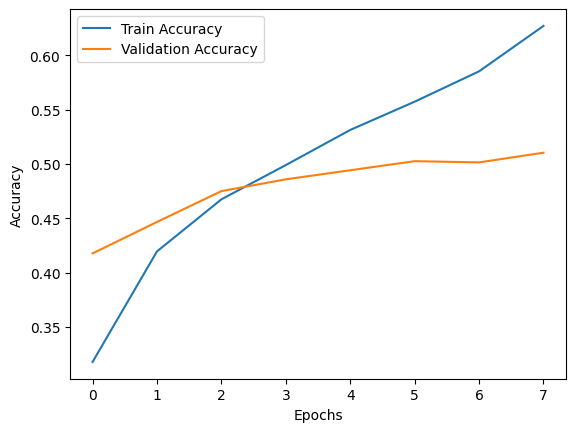

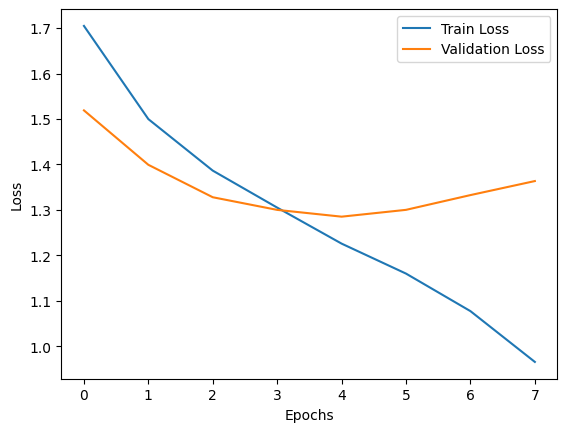

In [7]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()